# TP - Non-parametric regression (Cubic splines)
<h4 align="right"> Author: Hicham Janati </h4>

The motorcycle dataset records the head's acceleration after an accident as a function of time. Download and visualize the data:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


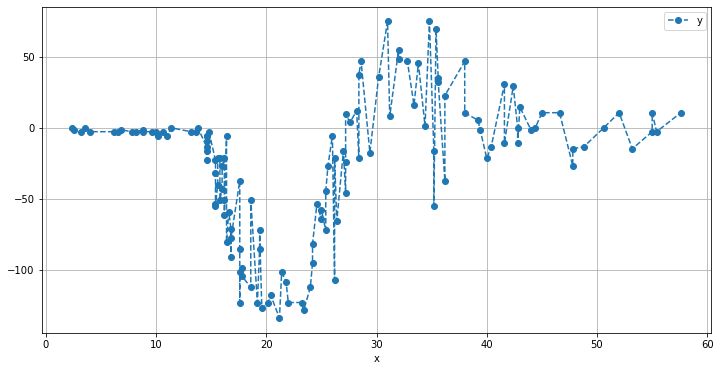

In [4]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
ax.grid()

In [6]:
df_raw

,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7
...,...,...
129,53.2,-14.7
130,55.0,-2.7
131,55.0,10.7
132,55.4,-2.7


#### Question 1
Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

In [12]:
# When there are several points for one give time xi, we consider the average of the points y
x_unique = np.unique(df_raw['x'])
weights = []
avg = []
for x in x_unique :
    tmp = df_raw.loc[df_raw['x']==x]
    weights.append(len(tmp))
    avg.append(tmp['y'].mean())

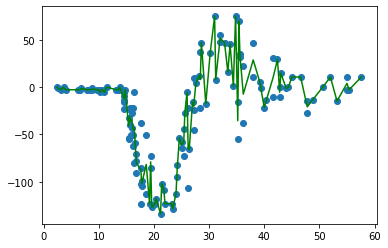

In [13]:
plt.scatter(df_raw['x'], df_raw['y'])
plt.plot(x_unique, avg, color = 'g')

### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

#### Question 2
Perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?

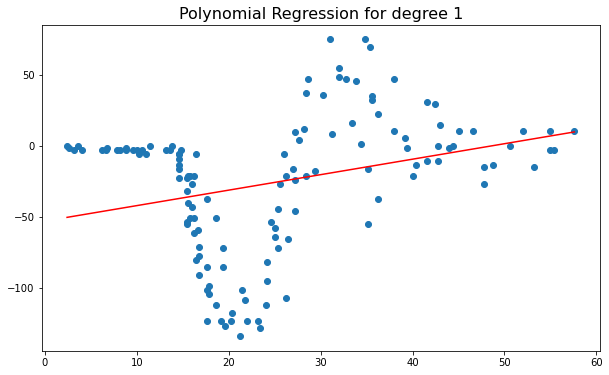

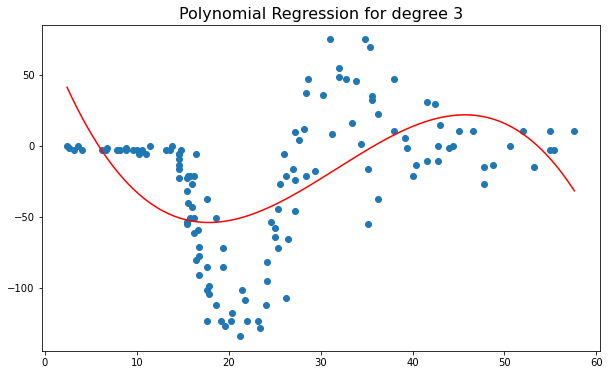

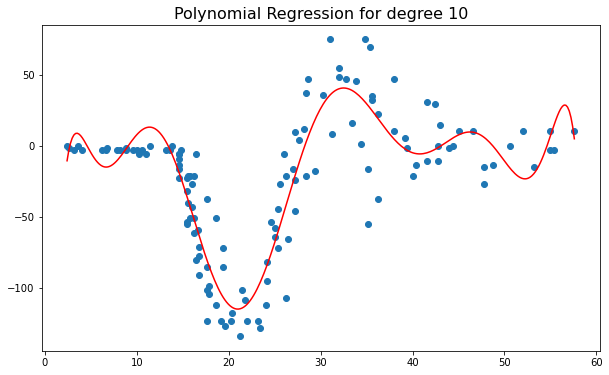

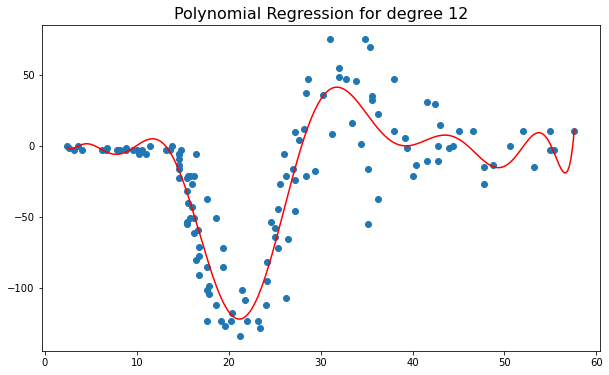

C:\Users\marga\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


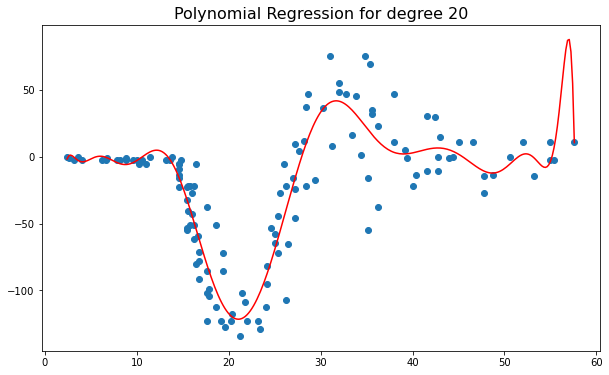

C:\Users\marga\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


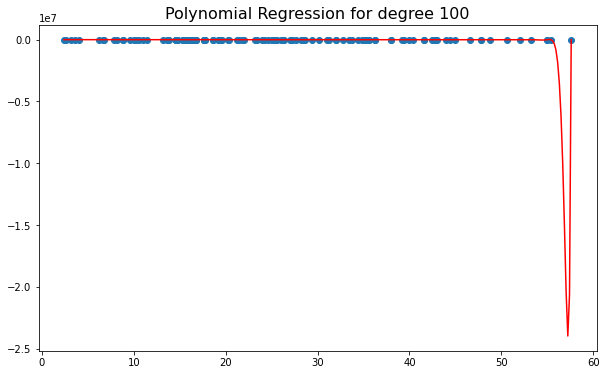

In [55]:
from sklearn.model_selection import train_test_split

degrees = [1, 3, 10, 12, 20, 100]
for d in degrees :

    X, y = df_raw['x'], df_raw['y']

    coefs = np.polyfit(X.values.flatten(), y.values.flatten(), d)
    X_seq = np.linspace(X.min(), X.max(), 300)
    
    plt.figure(figsize = (10,6))
    plt.title(f"Polynomial Regression for degree {d}", size = 16)
    plt.scatter(X, y)
    plt.plot(X_seq, np.polyval(coefs, X_seq), c = "red")
    plt.show()

Implementation of the polynomials model : $P_{\beta}(t) = \beta_{0} + \beta_{1}t + ... + \beta_{k}t^{k}$
The estimation is : 
But there are few problems with this method :
    - If $\beta$ is very large, then $k = n$ and the polynomial $P_{\beta}$ is doing interpolation of the data $(y,t)$
    - There might also have one or more regime switchings in the data (for example, flat then smooth and then flat). Then, fitting a unique polynomial function over the domain is a bad idea

## Cubic spline regression
#### Question 3
Complete the function `solve_splines_naive` that computes $g$ and $\gamma$ given the data. 

#### Question 4 
Knowing that $R + \alpha Q^\top Q$ is invertible, write an implementation of `solve_splines` that performs 0 matrix inversions.

In [58]:
def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    n = len(x)
    R, Q = _construct_R_Q(x)
    K = Q@np.linalg.inv(R)@Q.transpose()
    g = np.linalg.inv(np.eye(n) + alpha*K)@y
    gamma = np.linalg.inv(R)@Q.transpose()@g
    return g, gamma


def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    
    return g, gamma

In [ ]:
alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines(x, y, weights, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

#### Question 5
Implement a GCV function that returns the GCV score. Visualize the GCV score as a function of alpha.

In [ ]:
def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""

    return gcv_alpha


### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 

#### Question 6
Fill the class below and find the best Polynomial fit:


In [ ]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        
    def fit(self, x, y, weights=None):

        # todo 
        return self

    def predict(self, x):
        # todo
        return y

params = {"degree": np.arange(16)}

cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y)
poly_cv.best_estimator_

#### Question 7
See the content of `poly_cv.cv_results_` and plot the mean CV score as a function of the degree. 

#### Question 8
Visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

#### Question 9
Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, write a model that performs a polynomial.

#### Question 10
Perform cross validation on the degree of this model using scikit-learn.

#### Question 11
Find the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data point $x$. Visualize it on a grid of a few hundred regular points.